In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

2023-04-21 14:55:03.754472: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 14:55:03.764067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 14:55:03.832417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 14:55:03.833226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 14:55:04.466283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
wireplane = 'Z'

In [3]:
x_test = np.load('../../processed_data/current/x_test_' + wireplane + '.npy')
y_test = np.load('../../processed_data/current/y_test_AE_' + wireplane + '.npy')


mean = np.load('../results/mean_AE_' + wireplane + '.npy')
std = np.load('../results/std_AE_' + wireplane + '.npy')

In [4]:
x_test_scaled = (x_test-mean)/std
y_test_scaled = (y_test-mean)/std

In [5]:
max_adcs_test_signals = [max(abs(wave)) for wave in y_test if sum(abs(wave) != 0)]
print(sum(1 for val in max_adcs_test_signals if val < 20 and val !=0), len(max_adcs_test_signals))

22358 50000


In [6]:
len(max_adcs_test_signals)

50000

In [7]:
def custom_mse2(y_true, y_pred):

    return -1

In [8]:
cnn = load_model('../../latest_models/model_' + wireplane + 'plane_nu.h5')

autoencoder9 = load_model("../results/batch_size1_epochs_100_w1_1-w2_dot7_" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 20 epochs


In [9]:
%%time

predictions9 = autoencoder9.predict(x_test_scaled, batch_size=4096)
predictions9 = predictions9.reshape(predictions9.shape[0], predictions9.shape[1])

25/25 [==============================] - 1s 34ms/step
CPU times: user 3.45 s, sys: 354 ms, total: 3.8 s
Wall time: 1.38 s


In [10]:
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_ = y_test_scaled*std + mean

In [11]:
pred9 = predictions9*std + mean

In [12]:
from scipy import stats
print(stats.mode(pred9[0], keepdims=False)[0])

0.7170297


In [13]:
pred9 = pred9-stats.mode(pred9[0], keepdims=False)[0]

In [14]:
noise_data = [data for data in y_test_ if sum(abs(data)) == 0]

In [15]:
len(noise_data)

50000

In [16]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if np.std(ae_pred_wave) != 0 and max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


In [17]:
pred_labels = [label_predictions(wave) for wave in pred9]

In [18]:
len(pred_labels)

100000

In [19]:
def label_truths(wave):
    label_ = 0
    if sum(abs(wave)) != 0:
        label_ = 1
    return label_

In [20]:
truth_labels = [label_truths(t_wave) for t_wave in y_test]

In [21]:
len(truth_labels)

100000

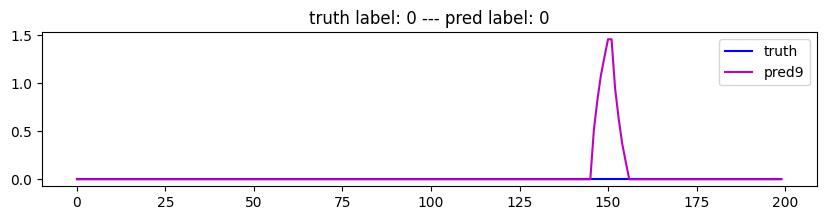

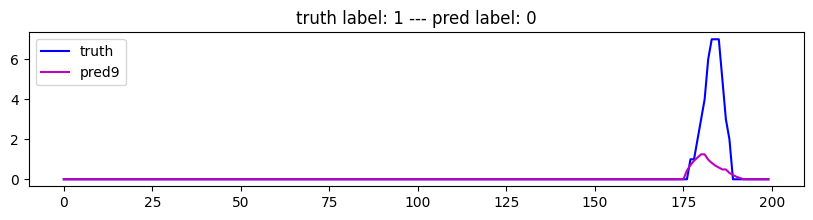

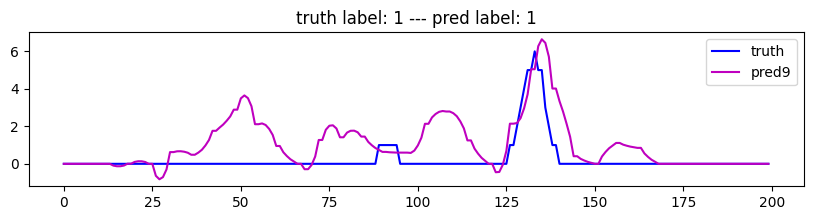

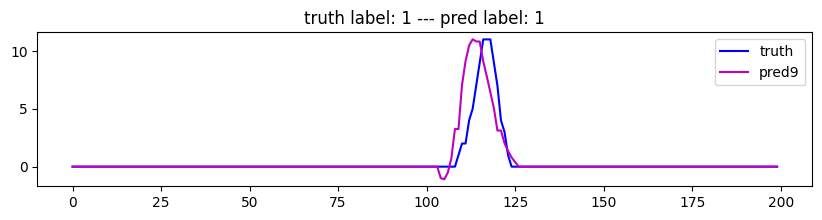

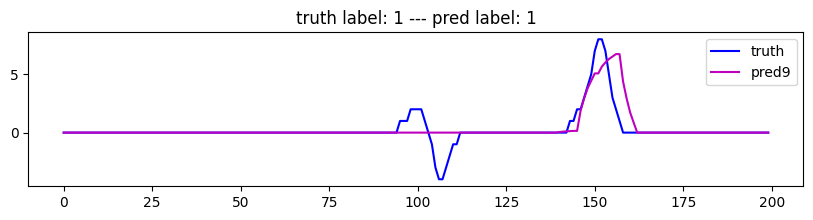

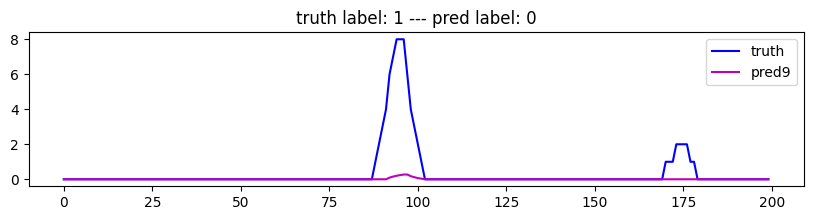

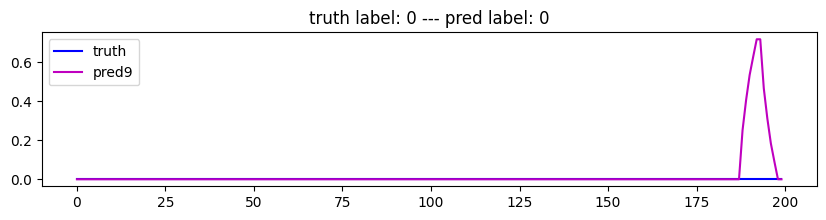

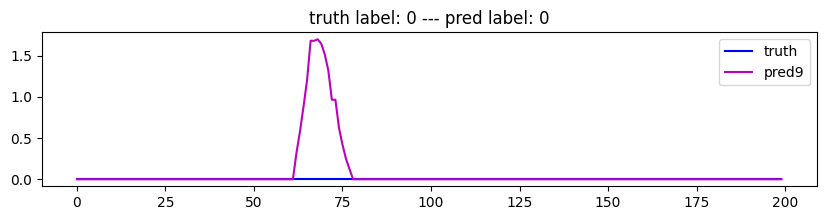

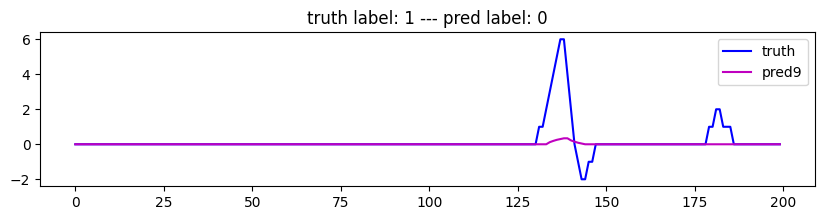

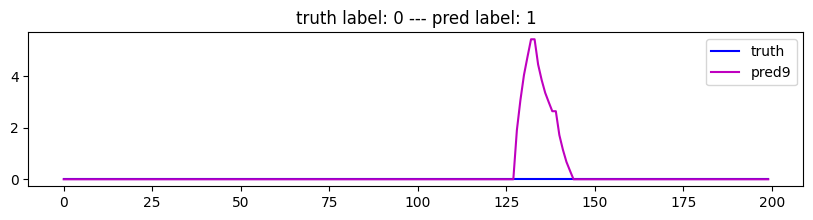

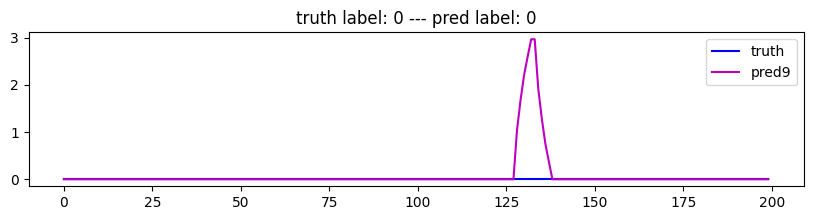

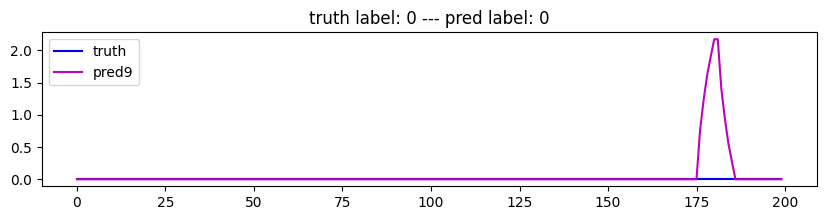

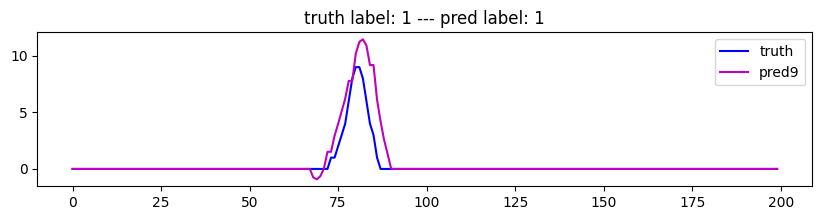

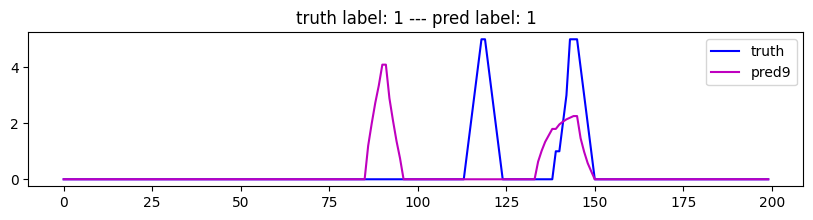

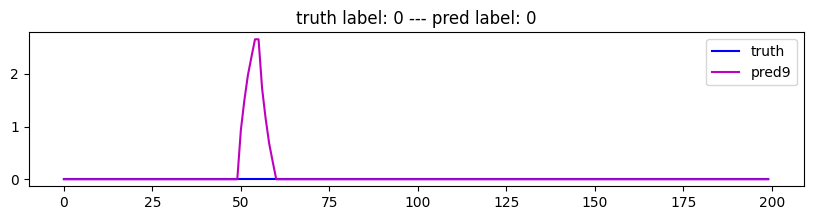

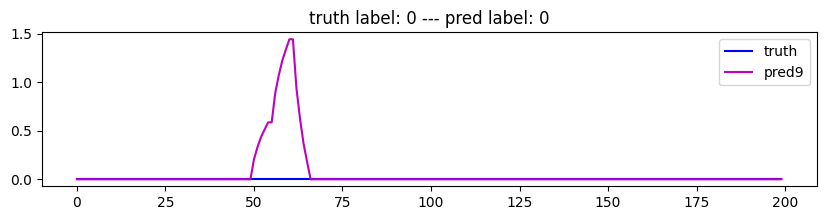

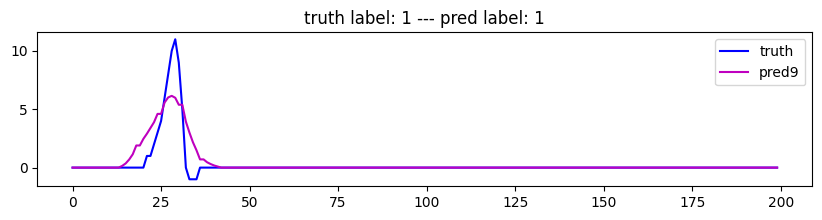

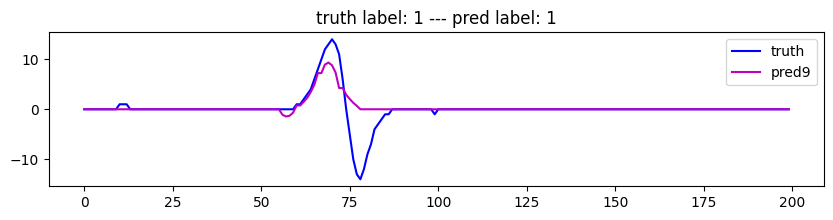

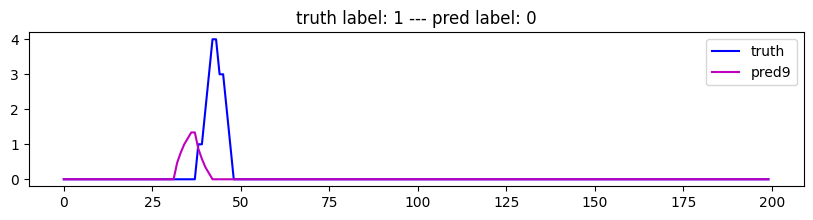

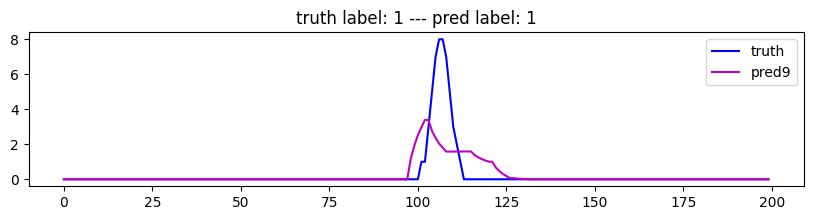

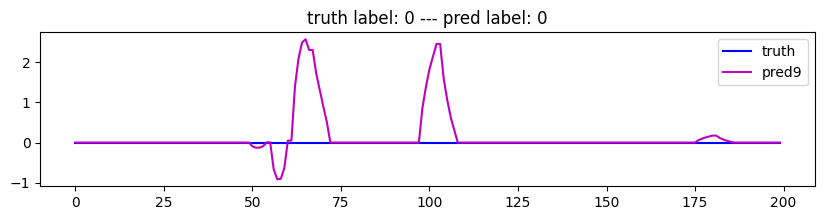

In [23]:
for i in range(100):
    if np.std(pred9[i]) != 0 and max(abs(y_test_[i])) < 15:
        fig = plt.figure(figsize=(10,2))
        plt.plot(y_test_[i], color='blue', label='truth')
        plt.plot(pred9[i], color='m', label='pred9')
        plt.title('truth label: ' + str(truth_labels[i]) + ' --- pred label: ' + str(pred_labels[i]))
        plt.legend()
        plt.show()


In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(truth_labels, pred_labels)
roc_auc = auc(fpr_keras, tpr_keras)

In [25]:
fpr_keras

array([0.     , 0.04338, 1.     ])

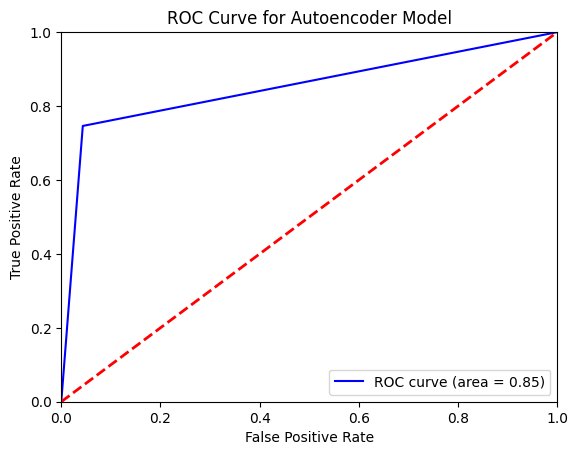

In [26]:
plt.plot(fpr_keras, tpr_keras, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Autoencoder Model')
plt.legend(loc="lower right")
plt.show()